In [1]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)

def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "BiasedMNIST",
            'fairness_agg': 'mean',
            # 'model': 'MLP',

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 15,
            'per_task_examples': np.inf,
            # 'per_task_examples': 1000,
            'per_task_memory_examples': 128,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 5.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            # 'criterion': torch.nn.BCEWithLogitsLoss(),

            'device': torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha': 0.0005,
            'metric' : "EO",
            'lambda': 0.5,
            'lambda_old': 0.0,
            
              }
    

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_tau={params['tau']}_alpha={params['alpha']}"
    if params['lambda'] != 0:
        trial_id+=f"_lmbd_{params['lambda']}_lmbdold_{params['lambda_old']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=BiasedMNIST/seed=0_epoch=15_lr=0.001_tau=5.0_alpha=0.0005_lmbd_0.5_lmbdold_0.0


In [2]:
"MNIST" in params['dataset']

True

In [3]:
from datasets import BiasedMNIST

if  params['dataset'] in ["BiasedMNIST"]:
    benchmark = BiasedMNIST(num_tasks=params['num_tasks'],
                                per_task_memory_examples=params['per_task_memory_examples'],
                                per_task_examples = params['per_task_examples'],
                                random_class_idx=False)
    input_dim = (3, 28, 28)
    class_idx = benchmark.class_idx
    num_classes = len(class_idx)

[0 1 2 3 4 5 6 7 8 9]


In [4]:
benchmark.mnist_train.sensitives

array([5, 0, 4, ..., 5, 6, 8])

In [5]:
from torchvision.transforms.functional import to_pil_image
from cl_gym.benchmarks.transforms import MNIST_MEAN, MNIST_STD
COLOR_MAP = {
    0: (1, 0, 0),
    1: (0, 1, 0),
    2: (1, 1, 0),
    3: (0, 0, 1),
    4: (1, 0.65, 0),
    5: (0.5, 0, 0.5),
    6: (0, 1, 1),
    7: (1, 0.75, 0.8),
    8: (0.8, 1, 0),
    9: (.588, .294, 0.)
}

r = (1 - 0.1913)
color_values = np.array(list(COLOR_MAP.values()))
m_rgb = color_values.mean(axis=0)
std_rgb = color_values.std(axis=0)

bmnist_mean = [r*m + MNIST_MEAN[0] for m in m_rgb]
bmnist_std = [(r*s**2+(1-r)*MNIST_STD[0]**2+r*(1-r)*(bmnist_mean[i] - m_rgb[i])**2)**0.5 for i, s in enumerate(std_rgb)]

unnormalize = torchvision.transforms.Normalize([-m/s for m, s in zip(bmnist_mean, bmnist_std)], [1/s for s in bmnist_std])
sample_idx = 95
to_pil_image(unnormalize(benchmark.trains[2][sample_idx][0]), mode="RGB")

In [6]:
target_label = 0
incremental_step = 1
# cat_img = torch.cat([img for img in benchmark.trains[incremental_step].inputs[benchmark.trains[incremental_step].targets == target_label][20:30]], dim=2)
cat_img = torch.cat([img for img, target, *_ in benchmark.tests[incremental_step]][20:30], dim=2)
to_pil_image(unnormalize(cat_img), mode="RGB")

In [7]:
from trainers import FairContinualTrainer
from trainers.fair_trainer import FairContinualTrainer2
from metrics import FairMetricCollector
from metrics import MetricCollector2

from algorithms import Heuristic3
from algorithms.fairl import FaIRL
from algorithms.icarl import iCaRL
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
# backbone = ResNet18Small2(
#         input_dim=input_dim, 
#         output_dim=num_classes,
#         class_idx=class_idx,
#         config=params
#     ).to(params['device'])
# algorithm = iCaRL(backbone, benchmark, params, requires_memory=True)
algorithm = Heuristic3(backbone, benchmark, params, requires_memory=True)

metric_manager_callback = FairMetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])
# metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
#                                                         eval_interval='epoch',
#                                                         epochs_per_task=params['epochs_per_task'])
from trainers.baselines import BaseMemoryContinualTrainer as ContinualTrainer

# trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])

trainer = FairContinualTrainer2(algorithm, params, callbacks=[metric_manager_callback])


In [8]:
algorithm.params['dataset'] == "BiasedMNIST"

True

In [9]:
if params['fairness_agg'] == "mean":
    agg = np.mean
elif params['fairness_agg'] == "max":
    agg = np.max
else:
    raise NotImplementedError

fairness_metrics = ["std", "EER", "EO", "DP"]
for metric in metric_manager_callback.meters:
    if metric in fairness_metrics:
        metric_manager_callback.meters[metric].agg = agg


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.8271127393688753, 'loss': 0.002176862884638721, 'std': 0.04737705654949209, 'EER': -1, 'EO': [0.4595588235294118, 0.25], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.6452205882352942, 'classwise_accuracy': {1: array([ 885, 1135]), 0: array([857, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 591, 0: 488}, 'class_pred_count_s1': {1: 417, 0: 619}, 'class_pred_count': {1: 1008, 0: 1107}, 'count_s0': 1079, 'count_s1': 1036, 'count': 2115}}
[2] Eval metrics for task 1 >> {'accuracy': 0.9061584105007642, 'loss': 0.0011422632081570636, 'std': 0.016290569091072515, 'EER': -1, 'EO': [0.1544715447154471, 0.22977941176470584], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.8078745217599235, 'classwise_accuracy': {0: array([904, 980]), 1: array([1010, 1135])}, 'DP_ingredients': {'class_pred_count_s0': {0: 488, 1: 591}, 'class_pred_count_s1': {1: 495, 0: 541}, 'class_pred_count': {0: 1

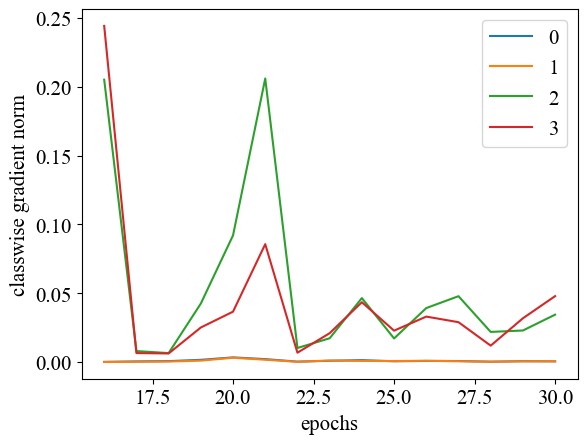

---------------------------- Task 3 -----------------------
losses=tensor([[2.0192e-04, 2.5299e-04, 1.1070e-01, 1.3535e-01, 1.0247e+01, 1.1160e+01,
         2.7968e-03, 4.3258e-03, 4.4801e-01, 2.3300e-01, 1.0499e+01, 1.1604e+01]])
Elapsed time(grad):4.213
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):7.383
Fairness:[-0.0084405  -0.00978147  0.04762471  0.04798226  0.02712961  0.04837424]
Current class expected loss:[ 0.          0.          0.          0.         -1.85754497 -2.15184943]
len(updated_seq_indices)=11263
Elapsed time(etc):0.274
[31] Eval metrics for task 1 >> {'accuracy': 0.946756720309269, 'loss': 0.0007866743749478748, 'std': 0.02328733255416704, 'EER': -1, 'EO': [0.0952952152472345, 0.05543943465711154], 'DP': -1, 'accuracy_s0': 0.9839636903275915, 'accuracy_s1': 0.9085963653754184, 'classwise_accuracy': {0: array([905, 980]), 1: array([1101, 1135])}, 'DP_ingredients': {'class_pred_count_s0': {0: 474, 1: 589, 4: 1, 5: 12, 3: 2, 2: 1}, 'cla

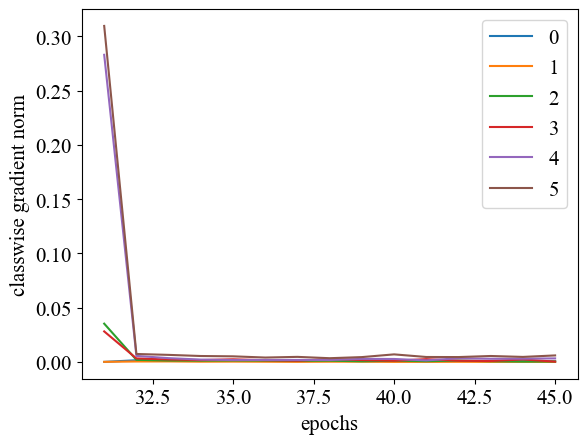

---------------------------- Task 4 -----------------------
losses=tensor([[1.0486e-03, 1.9140e-04, 7.5115e-04, 1.0739e-03, 7.2537e-03, 1.2986e-02,
         1.3221e+01, 8.1594e+00, 5.1056e-03, 3.7188e-03, 3.1732e-03, 1.1645e-02,
         1.0822e-01, 2.2699e-01, 1.4191e+01, 1.3178e+01]])
Elapsed time(grad):3.304
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):10.398
Fairness:[-0.009365    0.00798083  0.00164253 -0.00216259  0.01791345  0.05711296
  0.09175585  0.33758608]
Current class expected loss:[ 0.          0.          0.          0.          0.          0.
 -2.70592668 -1.89563332]
len(updated_seq_indices)=12183
Elapsed time(etc):0.212
[46] Eval metrics for task 1 >> {'accuracy': 0.9205295333992628, 'loss': 0.0014039354262340717, 'std': 0.03277443135844649, 'EER': -1, 'EO': [0.08683562257390265, 0.12153471944555505], 'DP': -1, 'accuracy_s0': 0.9718471748356494, 'accuracy_s1': 0.8676620038259206, 'classwise_accuracy': {1: array([1082, 1135]), 0: array([

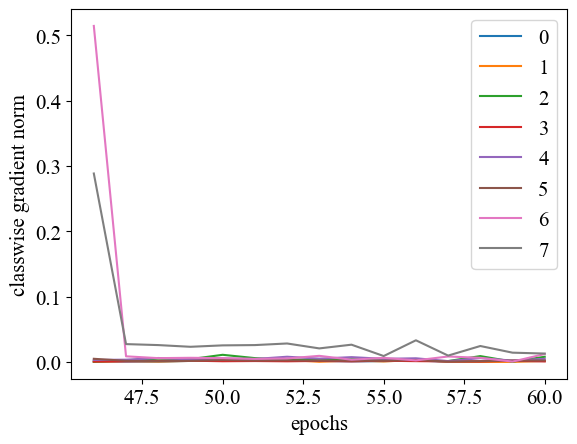

---------------------------- Task 5 -----------------------
losses=tensor([[1.5393e-03, 5.1279e-03, 4.5299e-03, 4.3940e-03, 4.9302e-03, 5.1974e-03,
         1.7630e-02, 9.6662e-02, 1.2134e+01, 1.7300e+01, 1.0865e-02, 9.7804e-03,
         2.1530e-02, 2.8801e-02, 1.3982e-02, 2.8516e-02, 1.4566e-01, 1.4070e-01,
         1.3554e+01, 1.5403e+01]])
Elapsed time(grad):3.658
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):11.485
Fairness:[-9.49690318e-03 -3.62296573e-03  4.75891673e-03 -1.47212320e-03
 -6.27365246e-05  2.33497523e-03 -6.85521429e-03  4.55743907e-03
  7.71772644e-02 -9.19521637e-02]
Current class expected loss:[ 0.          0.          0.          0.          0.          0.
  0.          0.         -2.57432941 -3.4284147 ]
len(updated_seq_indices)=11800
Elapsed time(etc):0.428
[61] Eval metrics for task 1 >> {'accuracy': 0.8896655578530972, 'loss': 0.0019269542913910346, 'std': 0.03456351703677063, 'EER': -1, 'EO': [0.12984597392256403, 0.19882047181

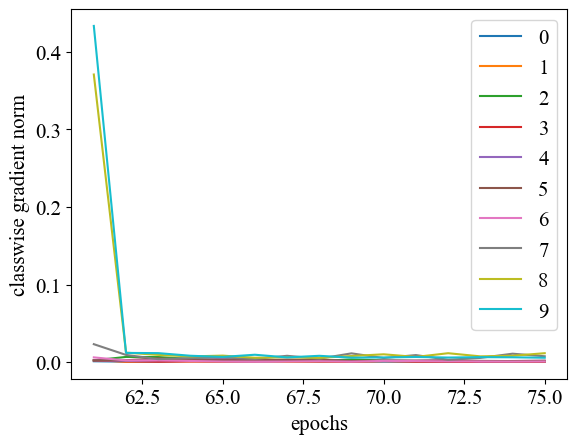

final avg-acc 0.8307358503935569
final avg-forget 0.13672480293265551


In [10]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [11]:
g = algorithm.grad_calculation_time
o = algorithm.optim_time
e = algorithm.etc_prepare_time
t = algorithm.overall_training_time


for task in range(2, 6):
    print(np.round(np.sum(list(g[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(o[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(e[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(t[task])), 4), end="\t")

63.3078	71.0796	56.3069	54.9338	
99.6859	107.1884	156.7727	176.7581	
4.3685	3.6712	3.5197	3.3436	
189.1389	205.8644	237.8032	256.7591	

In [ ]:
losses, *_ = algorithm.get_loss_grad_all(params['num_tasks']) 
algorithm.true_loss[params['num_tasks']][params['epochs_per_task']] = losses

num_epochs = params['epochs_per_task']
for task in range(2, params['num_tasks']):
    algorithm.true_loss[task][num_epochs] = algorithm.true_loss[task+1][0]

num_class_per_task = 2
t = algorithm.true_loss
e = algorithm.expected_loss
groupwise_true_loss = dict()
groupwise_expected_loss = dict()

for i in range(num_classes):
    groupwise_true_loss[i] = list()
    groupwise_expected_loss[i] = list()
    for j in range(2):
        groupwise_true_loss[i].append(dict())
        groupwise_expected_loss[i].append(dict())


for task in range(2, params['num_tasks']+1):
    for epoch in range(1, num_epochs+1):
        true_loss = np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        excepted_loss = np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        for i, (tl, el) in enumerate(zip(true_loss, excepted_loss)):
            if i < num_class_per_task*task:
                groupwise_true_loss[i][0][(task-1)*num_epochs+epoch] = tl
                groupwise_expected_loss[i][0][(task-1)*num_epochs+epoch] = el
            else:
                groupwise_true_loss[i-num_class_per_task*task][1][(task-1)*num_epochs+epoch] = tl
                groupwise_expected_loss[i-num_class_per_task*task][1][(task-1)*num_epochs+epoch] = el

            
    #     num_class_per_task
    #     print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print()
    # print()

for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][0][ce], end='\t')
    print()

for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][1][ce], end='\t')
    print()

for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][0][ce], end='\t')
    print()

for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][1][ce], end='\t')
    print()


In [12]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"DP:{np.mean(metric_manager_callback.meters['DP'].compute_overall())}")
print(f"EO:{np.mean(metric_manager_callback.meters['EO'].compute_overall())}")


accuracy:0.9067747093045382
DP:0.010199844271302256
EO:0.1257766350913639
